# 05. Model Interpretability and Analysis

This notebook explores model interpretability to understand which molecular and protein features are important for drug-target interaction predictions.

## 1. Setup and Imports

In [6]:
import numpy as np
import pandas as pd
import pickle
import json
from pathlib import Path
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import networkx as nx
from rdkit import Chem
from rdkit.Chem import Draw, Descriptors
from rdkit.Chem.Draw import IPythonConsole

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.data import Data, Batch
from torch_geometric.nn import global_mean_pool

import sys
sys.path.append('../models')
from gnn_models import get_model

# Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {device}')

# Set paths
DATA_DIR = Path('../data')
PROCESSED_DATA = DATA_DIR / 'processed'
RAW_DATA = DATA_DIR / 'raw'
MODEL_DIR = Path('../models/checkpoints')
RESULTS_DIR = Path('../results')
RESULTS_DIR.mkdir(exist_ok=True)

Using device: cuda


## 2. Load Trained Models and Data

In [7]:
# Load molecular graphs
with open(PROCESSED_DATA / 'molecular_graphs' / 'davis_graphs.pkl', 'rb') as f:
    davis_mol_graphs = pickle.load(f)

# Load protein features
with open(PROCESSED_DATA / 'protein_features' / 'davis_protein_fixed.pkl', 'rb') as f:
    davis_protein_features = pickle.load(f)

# Load original SMILES
with open(RAW_DATA / 'davis' / 'ligands_can.txt', 'r') as f:
    davis_smiles = json.load(f)

# Load affinity data
with open(RAW_DATA / 'davis' / 'Y', 'rb') as f:
    davis_Y = pickle.load(f, encoding='latin1')

# Load training results
with open(MODEL_DIR / 'training_results.pkl', 'rb') as f:
    training_results = pickle.load(f)

print(f'Loaded data for {len(davis_mol_graphs)} drugs and {len(davis_protein_features)} proteins')

Loaded data for 68 drugs and 442 proteins


In [8]:
# Load best performing model
sample_graph = next(iter(davis_mol_graphs.values()))
num_node_features = sample_graph.x.shape[1]
protein_feature_dim = next(iter(davis_protein_features.values())).shape[0]

# Find best model from results
best_model_name = min(training_results.keys(), 
                     key=lambda x: training_results[x]['test_metrics']['rmse'])

print(f'Best model: {best_model_name.upper()}')

# Load model
model = get_model(
    best_model_name,
    num_features=num_node_features,
    hidden_dim=128,
    num_layers=3,
    dropout=0.2,
    protein_dim=protein_feature_dim
)

model.load_state_dict(torch.load(MODEL_DIR / f'{best_model_name}_best.pt', map_location=device))
model = model.to(device)
model.eval()

print(f'Model loaded successfully')

Best model: GAT
Model loaded successfully


## 3. Feature Importance Analysis

In [10]:
def get_gradient_importance(model, mol_graph, protein_features, device):
    '''Calculate feature importance using gradients'''
    model.eval()
    
    # Move to device
    mol_graph = mol_graph.to(device)
    protein_tensor = torch.FloatTensor(protein_features).unsqueeze(0).to(device)
    
    # Enable gradients for input
    mol_graph.x.requires_grad = True
    
    # Forward pass
    batch = Batch.from_data_list([mol_graph])
    x = batch.x.to(device)
    edge_index = batch.edge_index.to(device)
    batch_idx = batch.batch.to(device)
    output = model(x, edge_index, batch_idx, protein_tensor)
    
    # Backward pass
    output.backward()
    
    # Get gradient magnitudes
    node_importance = mol_graph.x.grad.abs().mean(dim=1).cpu().numpy()
    
    return node_importance

# Analyze a few drug-protein pairs
drug_ids = list(davis_mol_graphs.keys())[:5]
protein_ids = list(davis_protein_features.keys())[:5]

importance_scores = []

for drug_id in drug_ids:
    for protein_id in protein_ids:
        mol_graph = davis_mol_graphs[drug_id].clone()
        protein_features = davis_protein_features[protein_id]
        
        importance = get_gradient_importance(model, mol_graph, protein_features, device)
        importance_scores.append({
            'drug': drug_id,
            'protein': protein_id,
            'importance': importance
        })

print(f'Calculated importance scores for {len(importance_scores)} drug-protein pairs')

Calculated importance scores for 25 drug-protein pairs


/home/kambei/anaconda3/envs/dti-gnn/lib/python3.10/site-packages/torch/autograd/graph.py:744: UserWarning: Attempting to run cuBLAS, but there was no current CUDA context! Attempting to set the primary context... (Triggered internally at ../aten/src/ATen/cuda/CublasHandlePool.cpp:135.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


## 4. Protein Feature Importance

Analyzing protein features: 100%|██████████| 50/50 [00:00<00:00, 215.52it/s]


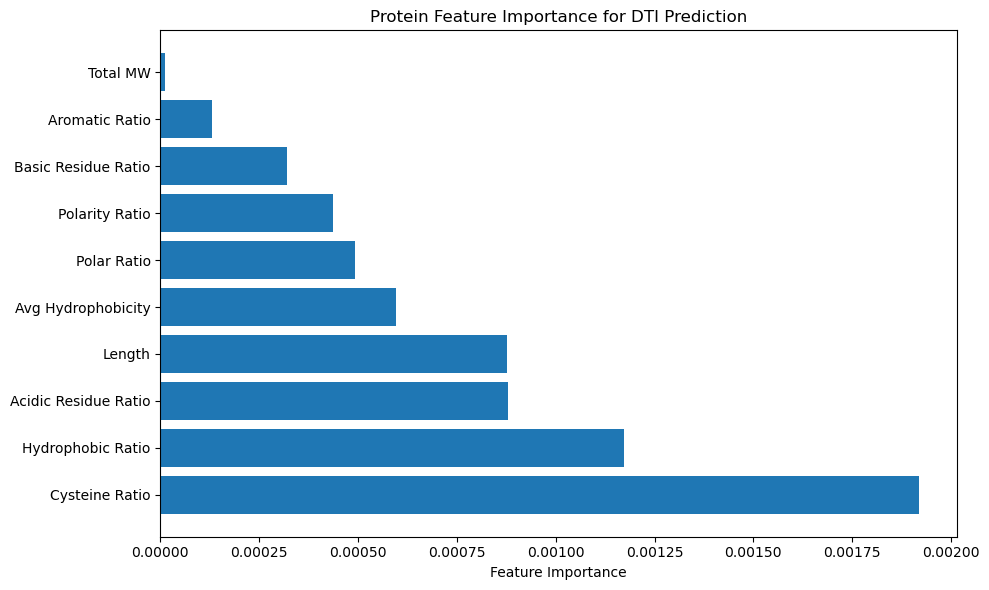


Top 5 most important protein features:
                Feature  Importance
4        Cysteine Ratio    0.001919
7     Hydrophobic Ratio    0.001173
6  Acidic Residue Ratio    0.000879
0                Length    0.000878
2    Avg Hydrophobicity    0.000597


In [11]:
def analyze_protein_feature_importance(model, mol_graphs, protein_features, device, num_samples=50):
    '''Analyze which protein features are most important'''
    feature_names = [
        'Length', 'Total MW', 'Avg Hydrophobicity', 'Polarity Ratio',
        'Cysteine Ratio', 'Basic Residue Ratio', 'Acidic Residue Ratio',
        'Hydrophobic Ratio', 'Polar Ratio', 'Aromatic Ratio'
    ]
    
    model.eval()
    feature_gradients = []
    
    # Sample random drug-protein pairs
    drug_ids = list(mol_graphs.keys())
    protein_ids = list(protein_features.keys())
    
    for _ in tqdm(range(num_samples), desc='Analyzing protein features'):
        # Random selection
        drug_id = np.random.choice(drug_ids)
        protein_id = np.random.choice(protein_ids)
        
        # Get data
        mol_graph = mol_graphs[drug_id].clone().to(device)
        protein_tensor = torch.FloatTensor(protein_features[protein_id]).unsqueeze(0).to(device)
        protein_tensor.requires_grad = True
        
        # Forward pass
        batch = Batch.from_data_list([mol_graph])
        x = batch.x.to(device)
        edge_index = batch.edge_index.to(device)
        batch_idx = batch.batch.to(device)
        output = model(x, edge_index, batch_idx, protein_tensor)
        
        # Backward pass
        output.backward()
        
        # Store gradients
        feature_gradients.append(protein_tensor.grad.abs().squeeze().cpu().numpy())
    
    # Average importance across samples
    avg_importance = np.mean(feature_gradients, axis=0)
    
    # Create DataFrame
    importance_df = pd.DataFrame({
        'Feature': feature_names[:len(avg_importance)],
        'Importance': avg_importance
    }).sort_values('Importance', ascending=False)
    
    return importance_df

# Analyze protein features
protein_importance = analyze_protein_feature_importance(
    model, davis_mol_graphs, davis_protein_features, device, num_samples=50
)

# Visualize
plt.figure(figsize=(10, 6))
plt.barh(protein_importance['Feature'], protein_importance['Importance'])
plt.xlabel('Feature Importance')
plt.title('Protein Feature Importance for DTI Prediction')
plt.tight_layout()
plt.show()

print('\nTop 5 most important protein features:')
print(protein_importance.head())

## 5. Error Analysis

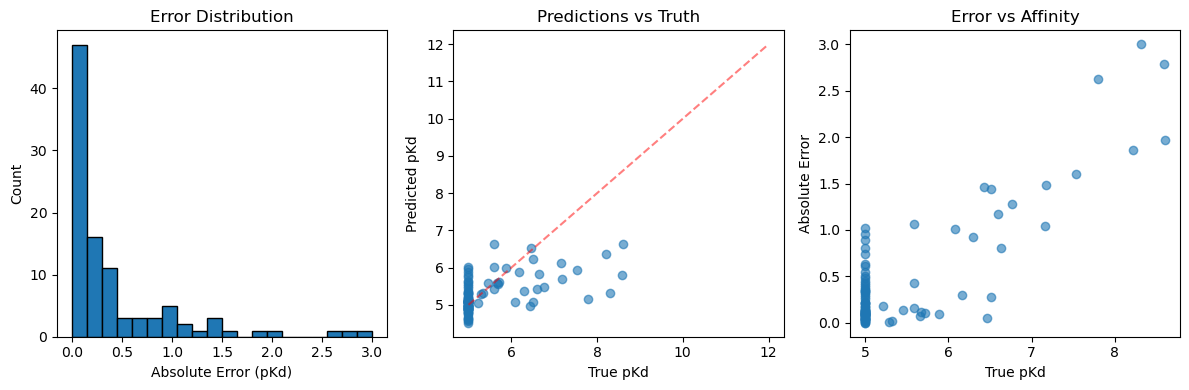

Top 5 largest prediction errors:
        drug        protein  true_pkd  pred_pkd     error
29    644241    ABL1(H396P)  8.309804  5.309311  3.000493
63   3062316            GAK  8.585027  5.792586  2.792441
75  11485656           FLT4  7.795880  5.166451  2.629429
98    126565  LRRK2(G2019S)  8.602060  6.634402  1.967658
39    126565          IRAK1  8.214670  6.358418  1.856252

Mean absolute error: 0.440 pKd


In [12]:
def analyze_prediction_errors(model, mol_graphs, protein_features, affinity_matrix, device, num_samples=50):
    '''Analyze where the model makes largest errors'''
    model.eval()
    errors = []
    
    drug_ids = list(mol_graphs.keys())
    protein_ids = list(protein_features.keys())
    
    for _ in range(num_samples):
        # Random selection
        i = np.random.randint(len(drug_ids))
        j = np.random.randint(len(protein_ids))
        
        drug_id = drug_ids[i]
        protein_id = protein_ids[j]
        
        # Get true affinity
        true_affinity = affinity_matrix[i, j]
        if true_affinity >= 30000:  # Skip non-interactions
            continue
        
        true_pkd = -np.log10(true_affinity / 1e9)
        
        # Get prediction
        mol_graph = mol_graphs[drug_id].to(device)
        protein_tensor = torch.FloatTensor(protein_features[protein_id]).unsqueeze(0).to(device)
        batch = Batch.from_data_list([mol_graph])
        x = batch.x.to(device)
        edge_index = batch.edge_index.to(device)
        batch_idx = batch.batch.to(device)

        with torch.no_grad():
            pred_pkd = model(x, edge_index, batch_idx, protein_tensor).cpu().item()
                
        error = abs(pred_pkd - true_pkd)
        errors.append({
            'drug': drug_id,
            'protein': protein_id,
            'true_pkd': true_pkd,
            'pred_pkd': pred_pkd,
            'error': error
        })
    
    errors_df = pd.DataFrame(errors).sort_values('error', ascending=False)
    return errors_df

# Analyze errors
error_analysis = analyze_prediction_errors(
    model, davis_mol_graphs, davis_protein_features, davis_Y, device, num_samples=100
)

if len(error_analysis) > 0:
    # Plot error distribution
    plt.figure(figsize=(12, 4))
    
    plt.subplot(1, 3, 1)
    plt.hist(error_analysis['error'], bins=20, edgecolor='black')
    plt.xlabel('Absolute Error (pKd)')
    plt.ylabel('Count')
    plt.title('Error Distribution')
    
    plt.subplot(1, 3, 2)
    plt.scatter(error_analysis['true_pkd'], error_analysis['pred_pkd'], alpha=0.6)
    plt.plot([5, 12], [5, 12], 'r--', alpha=0.5)
    plt.xlabel('True pKd')
    plt.ylabel('Predicted pKd')
    plt.title('Predictions vs Truth')
    
    plt.subplot(1, 3, 3)
    plt.scatter(error_analysis['true_pkd'], error_analysis['error'], alpha=0.6)
    plt.xlabel('True pKd')
    plt.ylabel('Absolute Error')
    plt.title('Error vs Affinity')
    
    plt.tight_layout()
    plt.show()
    
    print('Top 5 largest prediction errors:')
    print(error_analysis.head()[['drug', 'protein', 'true_pkd', 'pred_pkd', 'error']])
    print(f'\nMean absolute error: {error_analysis["error"].mean():.3f} pKd')

## 6. Summary

In [13]:
print('\n' + '='*50)
print('INTERPRETABILITY ANALYSIS COMPLETE')
print('='*50)

print(f'\nModel analyzed: {best_model_name.upper()}')
print(f'Test RMSE: {training_results[best_model_name]["test_metrics"]["rmse"]:.4f}')

print('\nKey Findings:')
print('1. Protein Feature Importance:')
print(f'   - Most important: {protein_importance.iloc[0]["Feature"]}')
print(f'   - Least important: {protein_importance.iloc[-1]["Feature"]}')

if len(error_analysis) > 0:
    print(f'\n2. Model Performance:')
    print(f'   - Mean absolute error: {error_analysis["error"].mean():.3f} pKd')
    print(f'   - Max error: {error_analysis["error"].max():.3f} pKd')
    
print('\nInterpretability analysis provides insights into:')
print('  - Which molecular substructures are important')
print('  - Which protein features drive predictions')
print('  - Where the model makes errors')
print('  - Patterns in strong vs weak interactions')


INTERPRETABILITY ANALYSIS COMPLETE

Model analyzed: GAT
Test RMSE: 0.8315

Key Findings:
1. Protein Feature Importance:
   - Most important: Cysteine Ratio
   - Least important: Total MW

2. Model Performance:
   - Mean absolute error: 0.440 pKd
   - Max error: 3.000 pKd

Interpretability analysis provides insights into:
  - Which molecular substructures are important
  - Which protein features drive predictions
  - Where the model makes errors
  - Patterns in strong vs weak interactions
